In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
reviews = pd.read_csv('Reviews.csv')
unique_users = reviews.UserId.unique()
unique_products = reviews.ProductId.unique()

In [45]:
subset = reviews.ix[:10000,:]

times = pd.to_datetime(subset['Time'], unit='s')

# http://stackoverflow.com/questions/25146121/extracting-just-month-and-year-from-pandas-datetime-column-python
subset['Year'] = pd.DatetimeIndex(times).year
subset['Month'] = pd.DatetimeIndex(times).month
subset['Day'] = pd.DatetimeIndex(times).day
subset['DayofYear'] = pd.DatetimeIndex(times).dayofyear

subset.head()

C:\Users\Catherine\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Catherine\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Catherine\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Year,Month,Day,DayofYear
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011,4,27,117
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012,9,7,251
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008,8,18,231
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011,6,13,164
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012,10,21,295


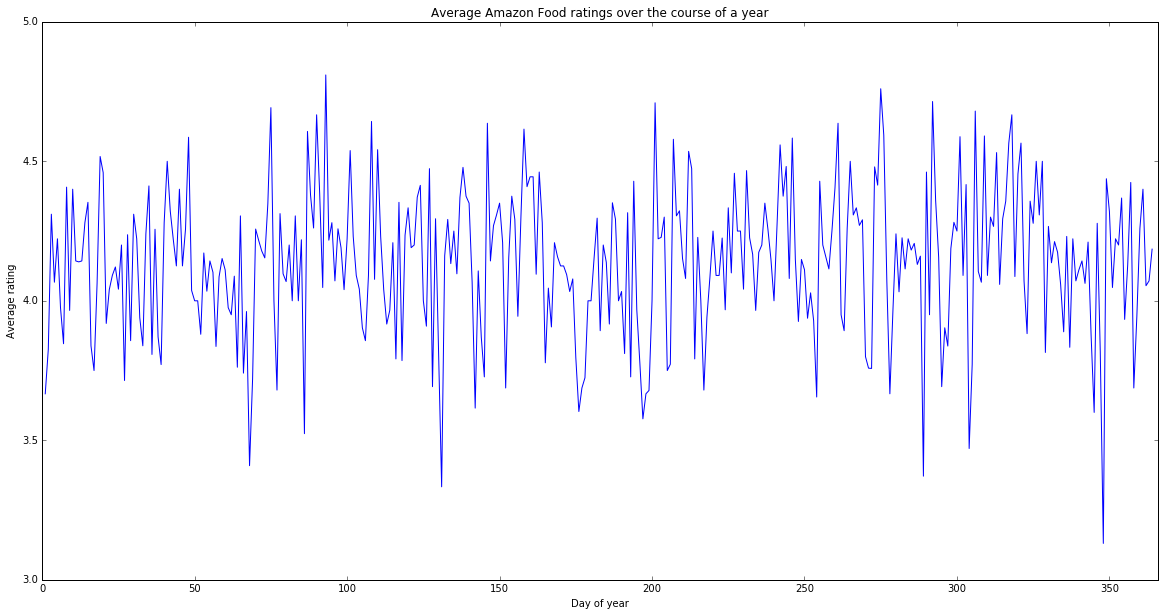

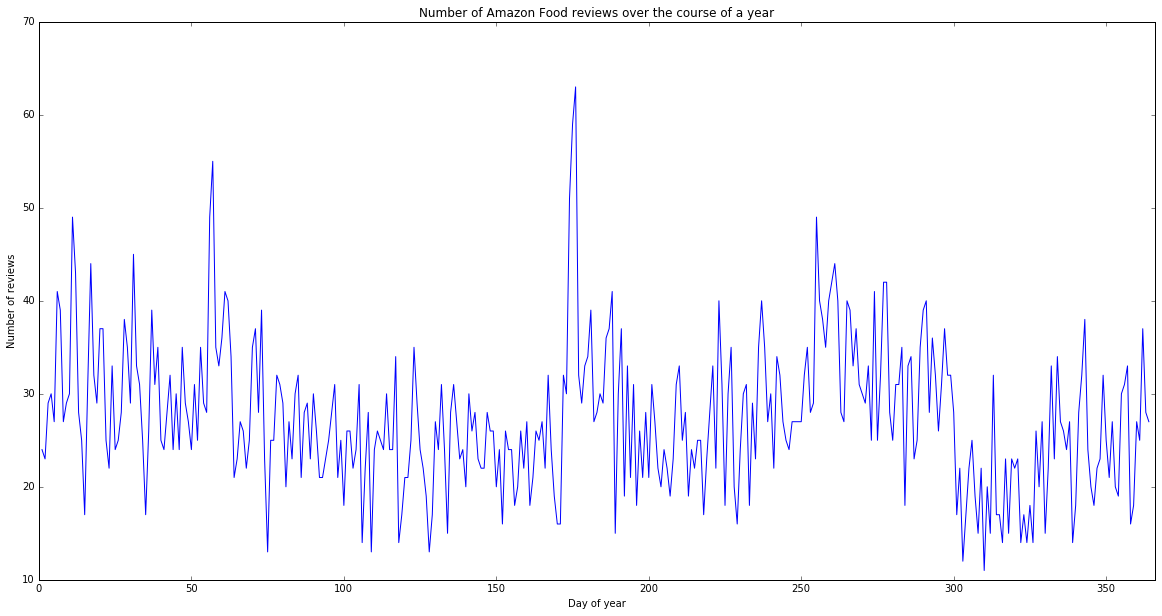

In [64]:
# Explore how reviews and timestamp are related!

avg_scores = []
num_reviews = []
proportion_good = []

for day in range(1, 365):
    scores = subset[subset['DayofYear'] == day]['Score']
    avg_scores.append(np.mean(scores.values))
    num_reviews.append(len(scores))
    

plt.figure(figsize=(20,10))
plt.plot(range(1, 365), avg_scores)
plt.title('Average Amazon Food ratings over the course of a year')
plt.xlim([0, 366])
plt.xlabel('Day of year')
plt.ylabel('Average rating')

plt.figure(figsize=(20,10))
plt.plot(range(1, 365), num_reviews)
plt.title('Number of Amazon Food reviews over the course of a year')
plt.xlim([0, 366])
plt.xlabel('Day of year')
plt.ylabel('Number of reviews')


## Baseline Model:
- Simple Averaging: A simple baseline model is to use the average of all other scores of a particular product to predict how a user will rate the product. If there is no other data on the product we guess 3.
- Content based recommendation: Given a product, recommend the most similar products based on content of user reviews and summaries for those products. 

### 1. Simple Averaging

In [5]:
#Uses average score to predict how a user will score, for the first 10000 observations
def compute_baseline_error():
    l1score = []
    misclassified = []

    for i in  range(10000):
        correct = 0 
        score = reviews.ix[i,:].Score
        product = reviews.ix[i,:].ProductId
        ID = reviews.ix[i,:].Id
        other_reviews = reviews[(reviews.ProductId == product) & (reviews.Id != ID)].Score.values
        if len(other_reviews) == 0:
            guess = 3 
        else:
            guess = other_reviews.mean()
        
        offby = guess - score
        if int(guess+0.5) == int(score):
            correct = 1
        
        l1score.append(offby)
        misclassified.append(correct)
    return l1score,misclassified

In [6]:
import time 
start = time.time()
l,m = compute_baseline_error()
end = time.time()
print end - start

323.726979971


In [8]:
print "Fraction Correctly Classified: ", sum(m)/float(len(m))

Fraction Correctly Classified:  0.3287


We can also relabel good (4,5) or bad (1,2,3) scores as 1 and 0 and see how well this does, guessing 1 if there's no data (justify later but people are probably more likely to give positive reviews than negative ones). 

In [ ]:
def modified_baseline_error():
    misclassified = []

    for i in  range(10000):
        correct = 0 
        score = reviews.ix[i,:].Score
        product = reviews.ix[i,:].ProductId
        ID = reviews.ix[i,:].Id
        other_reviews = reviews[(reviews.ProductId == product) & (reviews.Id != ID)].Score.values
        if len(other_reviews) == 0:
            guess = 5 
        else:
            guess = other_reviews.mean()
        
        if guess >= 3.5:
            new_guess = 1
        else:
            new_guess = 0
        if score >=3.5:
            new_score = 1
        else:
            new_score = 0
                
        if new_guess == new_score:
            misclassified.append(1)
        else:
            misclassified.append(0)
    return misclassified

In [16]:
import time 
start = time.time()
m = modified_baseline_error()
end = time.time()
print end - start

312.308862925


In [20]:
print 'Fraction Correctly Classified: ', sum(m)/float(len(m))

Fraction Correctly Classified:  0.7487


So given a product is rated an average of 3.5 or above, there is a .75 chance that the user rates the product as 4 or 5. This can be modified to recommend the products with highest average rating to all users. 

### 2. Content Based Recommendation
Given that a user is viewing/ purchased a particular item, recommend items that are very similar to that item based on the summary and content of reviews.
- **Input**: Product ID (viewed/purchased item) , Similarity Matrix based on Cosine similarity score of Term Frequency Inverse Document Frequency Vectors
- **Output**: List of Product IDs of Similar Products and associated similarity score

In [5]:
#Useful Packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.spatial.distance import cosine
from scipy.cluster.vq import vq,kmeans,whiten
import time

First, I created a new dataframe with unique products and their associated text by appending all reviews/ summaries associated with a particular product together. This is slow, so I only used the first 1000 products.

In [8]:
#whole thing takes a long time(>30minutes), use first 1000 products
start = time.time()
unique_prod_reviews = map(lambda x: to_words(x),unique_products[0:1000])
end = time.time()
print end - start

95.0920000076


In [9]:
product_df = pd.DataFrame()
product_df['ProductId'] = unique_products[0:1000]
product_df['Text'] = unique_prod_reviews
product_df.head()

,ProductId,Text
0,B001E4KFG0,[I have bought several of the Vitality canned ...
1,B00813GRG4,[Product arrived labeled as Jumbo Salted Peanu...
2,B000LQOCH0,[This is a confection that has been around a f...
3,B000UA0QIQ,[If you are looking for the secret ingredient ...
4,B006K2ZZ7K,[Great taffy at a great price. There was a wi...


Use SKLearn's implementation of TF-IDF to get a sparse vector for each item , then use linear-kernel to get cosine similary scores between items and store these in a 1000x1000 matrix

In [10]:
a = np.array(unique_prod_reviews)
a = a.reshape(len(a),)
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(a)

In [11]:
tfidf_matrix.toarray()
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_similarities

array([[  1.00000000e+00,   5.36110174e-03,   0.00000000e+00, ...,
          8.28603989e-03,   5.19533133e-03,   5.02833995e-03],
       [  5.36110174e-03,   1.00000000e+00,   0.00000000e+00, ...,
          5.29899866e-03,   0.00000000e+00,   1.78627910e-03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  8.28603989e-03,   5.29899866e-03,   0.00000000e+00, ...,
          1.00000000e+00,   8.30201976e-03,   7.89411311e-04],
       [  5.19533133e-03,   0.00000000e+00,   0.00000000e+00, ...,
          8.30201976e-03,   1.00000000e+00,   4.70532436e-03],
       [  5.02833995e-03,   1.78627910e-03,   0.00000000e+00, ...,
          7.89411311e-04,   4.70532436e-03,   1.00000000e+00]])

Above is the TF-IDF Matrix for the first 1000 products. Below I wrote a function to return 8 most similar items given a product ID and similarity matrix as input.

In [19]:
#takes a product name in the unique products data and returns the 8 most similar products
#input: Product ID, Product Dataframe, Similarity Matrix
#output: Array of 8 nearest items in the database using cosine similarity

def return_nearest(product,cosine_similarities,product_df):
    idx = product_df[product_df.ProductId == product].index[0]
    similar_indices = cosine_similarities[idx].argsort()[:-10:-1]
    similar_items = [(cosine_similarities[idx][i], product_df['ProductId'][i]) for i in similar_indices]
    return similar_items[1:]


In [31]:
return_nearest('B00813GRG4',cosine_similarities,product_df)

[(0.060071873611170931, 'B000CMFMG8'),
 (0.052140838382313696, 'B0047LRBX2'),
 (0.043432096349825311, 'B001EO6BCC'),
 (0.037325003722012799, 'B000G6RPMY'),
 (0.026276191344016604, 'B001FA1L7U'),
 (0.025318462964514555, 'B004AVYUOW'),
 (0.025057186536542934, 'B001HOUGFC'),
 (0.023818763987623219, 'B000YT5DBS')]

- Searching the product IDs on Amazon, the input product is a brand of peanut, and most of the recommended items are different types of peanuts. The downside of this approach is that the items recommended are too similar to the product that the user viewed/purchased, so it is unlikely that the recommender will generate much revenue that the companies would not have already received. 
- For the simple averaging recommender, very highly rated items are recommended, but they aren't related to what the user is viewing. 

### 3. Collaborative Filtering

In [12]:
# Only look at the first 1000 reviews for now
reviews_1000 = reviews.ix[:1000, :]

# Extract unique users and products from this subset of reviews
unique_users_1000 = reviews_1000.UserId.unique()
unique_products_1000 = reviews_1000.ProductId.unique()

print "Number of unique users among first 1000 reviews:", len(unique_users_1000)
print "Number of unique products among first 1000 reviews:", len(unique_products_1000)


Number of unique users among first 1000 reviews: 966
Number of unique products among first 1000 reviews: 208


In [49]:
# Note that the cosine similarities matrix from part 2 contains information for the first 1000 unique products
# We'll only use the 208 unique products that appear in the first 1000 reviews
cosine_similarities_1000 = cosine_similarities[:208, :208]
cosine_similarities_1000

array([[ 1.        ,  0.0053611 ,  0.        , ...,  0.        ,
         0.00586703,  0.00470555],
       [ 0.0053611 ,  1.        ,  0.        , ...,  0.        ,
         0.00150435,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.00631487,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.01151698,  0.        ],
       [ 0.00586703,  0.00150435,  0.00631487, ...,  0.01151698,
         1.        ,  0.00781604],
       [ 0.00470555,  0.        ,  0.        , ...,  0.        ,
         0.00781604,  1.        ]])

In [39]:
# Reformat the first 1000 reviews such that each row is a user ID, each column is a product
# Fill entries: 1 indicates that the user corresponding to therow reviewed the product corresponding to the column
# (regardless of rating);
# All other entries are 0

reviews_1000_reformatted = pd.DataFrame(index=unique_users_1000,columns=unique_products_1000)

for i in range(1000):
    rev = reviews_1000.ix[i, :]
    user = rev['UserId']; product = rev['ProductId']; score = rev['Score']
    reviews_1000_reformatted.ix[user, product] = 1
    
reviews_1000_reformatted = reviews_1000_reformatted.fillna(0)

In [40]:
reviews_1000_reformatted.head()

,B001E4KFG0,B00813GRG4,B000LQOCH0,B000UA0QIQ,B006K2ZZ7K,B000E7L2R4,B00171APVA,B0001PB9FE,B0009XLVG0,B001GVISJM,...,B005NEXK6Y,B00448SNSA,B0002XIB2Y,B000F0G75W,B001EQ4DVQ,B004DTNJU2,B00473OV2E,B0048IACB2,B006F2NYI2,B004A8VV42
A3SGXH7AUHU8GW,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1D87F6ZCVE5NK,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABXLMWJIXXAIN,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A395BORC6FGVXV,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1UQRSCLF8GW1T,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
user_based_recs = pd.DataFrame(index=unique_users_1000,columns=unique_products_1000)

In [44]:
# Helper function to get similarity scores
# This weights a set of entries in our cosine_similarities matrix using a user's review history
# BASED ON http://www.salemmarafi.com/code/collaborative-filtering-with-python/
def getScore(history, similarities):
    return sum(history*similarities)/sum(similarities)

In [52]:
#Loop through all user and item combinations. Fill with similarity scores based on our getScore function,
# which takes into account the historical "likes" of a user AND the cosine similarities we calculated before
for i in range(0, len(user_based_recs.index)):
    for j in range(1, len(user_based_recs.columns)):
        user = user_based_recs.index[i]
        product = user_based_recs.columns[j]
 
        if (reviews_1000_reformatted.ix[i, j] == 1):
        # If user has already reviewed a product, don't recommend it again
            user_based_recs.ix[i, j] = 0
        else:
            # Use function in part 2 to grab 8 nearest neighbors to the product we're looking at
            # This yields a list of tuples: (similarity score, product name)
            top_products = return_nearest(product, cosine_similarities_1000, product_df)
            top_product_names = [x[1] for x in top_products] # Extract product names from 8 nearest neighbors
            top_product_sims = [x[0] for x in top_products] # Extract similarity scores from 8 nearest neighbors
            user_purchases = reviews_1000_reformatted.ix[user, top_product_names].values
 
            user_based_recs.ix[i, j] = getScore(user_purchases, top_product_sims)

In [53]:
user_based_recs.head()

,B001E4KFG0,B00813GRG4,B000LQOCH0,B000UA0QIQ,B006K2ZZ7K,B000E7L2R4,B00171APVA,B0001PB9FE,B0009XLVG0,B001GVISJM,...,B005NEXK6Y,B00448SNSA,B0002XIB2Y,B000F0G75W,B001EQ4DVQ,B004DTNJU2,B00473OV2E,B0048IACB2,B006F2NYI2,B004A8VV42
A3SGXH7AUHU8GW,NaN,0,0,0,0,0,0.158688,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1D87F6ZCVE5NK,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABXLMWJIXXAIN,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A395BORC6FGVXV,NaN,0,0,0,0.12294,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1UQRSCLF8GW1T,NaN,0,0.128287,0.167951,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
#takes a product name in the unique products data and returns the 8 most similar products
#input: User ID, user-based recommendation matrix
#output: 8 recommended products

def user_recommend(user, user_based_recs):
    row = user_based_recs.ix[user, :]
    sorted_row = row.sort_values(ascending = False)
    
    return sorted_row[0:8]
    

In [69]:
# Try getting recommendations for user A3SGXH7AUHU8GW
user_recommend('A3SGXH7AUHU8GW', user_based_recs)

B005Y0DXBO     0.184012
B001IZM8A6     0.166594
B00171APVA     0.158688
B0019CW0HE      0.12954
B0002567IW     0.120913
B003AO5DLO    0.0972636
B0064KU9HO    0.0900858
B003VTN95K            0
Name: A3SGXH7AUHU8GW, dtype: object